# Classify Leads
## Data Preprocessing


This notebook includes:

1. Exploratory Data Analysis
2. Data Cleaning
3. Feature Engineering


----
## Exploratory Data Analysis


In [1]:
pip install translate

^C
Note: you may need to restart the kernel to use updated packages.


In [91]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
import seaborn as sb
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
import re
from translate import Translator
from nltk.corpus import names
import datetime
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from sqlalchemy import create_engine

# Pretty display for notebooks
%matplotlib inline


In [2]:
# Load nawy dataset
df = pd.read_csv("data/nawy_dataset.csv")

# display the dataset
df.head()


C:\Users\EL7md\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,lead_id,customer_name,lead_mobile_network,message,lead_time,method_of_contact,ad_group,lead_source,campaign,location,low_qualified,Unnamed: 11,Unnamed: 12
0,22,Rajaa M.Mousa,Orange,message: Idea about the best area in Sheik Za...,2022-03-07 12:56:20.523509,generic form,none,google,dev_-_sodic,sodic october plaza,0,NaN,NaN
1,30,Sahar Shalaby,Vodafone,ad_id : 23843176891470664 \nform_id : 36774549...,2019-09-16 13:17:18.459000,facebook,o west - fb_creme de la creme_ cairo/giza_27-60,facebook,orascom - lead generation,o west,0,NaN,NaN
2,42,Mohamed,Vodafone,message:,2022-05-07 02:03:53.589687,generic form,gouna_-_properties,google,locations,el gouna for sale & resale,0,NaN,NaN
3,44,Maher Elnakib,Orange,ad_id : 23844249544660664 \nadset_id : 2384424...,2019-12-19 22:56:46.662000,facebook,new release north edge general with north coas...,facebook,city edge - lead generation,north edge,0,NaN,NaN
4,48,pierre,Vodafone,message:,2022-01-27 05:56:22.806753,top compounds form,none,google,dev_-_inertia_egypt,joulz,0,NaN,NaN


In [3]:
# print the shape of the dataset
df.shape

(91129, 13)

In [4]:
# print the info of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91129 entries, 0 to 91128
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   lead_id              91129 non-null  int64  
 1   customer_name        91129 non-null  object 
 2   lead_mobile_network  91128 non-null  object 
 3   message              89091 non-null  object 
 4   lead_time            91129 non-null  object 
 5   method_of_contact    91129 non-null  object 
 6   ad_group             91057 non-null  object 
 7   lead_source          91129 non-null  object 
 8   campaign             90349 non-null  object 
 9   location             90980 non-null  object 
 10  low_qualified        91129 non-null  object 
 11  Unnamed: 11          8 non-null      object 
 12  Unnamed: 12          1 non-null      float64
dtypes: float64(1), int64(1), object(11)
memory usage: 9.0+ MB


> There are null values and the data types are not appropriate.

In [5]:
# check missing values
df.isnull().sum()

lead_id                    0
customer_name              0
lead_mobile_network        1
message                 2038
lead_time                  0
method_of_contact          0
ad_group                  72
lead_source                0
campaign                 780
location                 149
low_qualified              0
Unnamed: 11            91121
Unnamed: 12            91128
dtype: int64

> There are null values in message, ad_group, campaign and location columns.

#### Explore the qualifed leads and unqualifed leads separately

In [6]:
# function that returns the unique using specific dataset and feature
def d_unique(data,feature):
    
    return data[feature].unique()

In [7]:
# function that returns the number of unique using specific dataset and feature
def n_unique(data,feature):
    
    return data[feature].nunique()

In [8]:
# explore the qualified leads
qua_df=df.query('low_qualified== "1"')
qua_df.head()

,lead_id,customer_name,lead_mobile_network,message,lead_time,method_of_contact,ad_group,lead_source,campaign,location,low_qualified,Unnamed: 11,Unnamed: 12
7,70,Gaber youssef,Vodafone,location : https://old.nawy.com/prime-compound...,2021-10-03 21:58:29.602753,generic form,none,google,dev_-_sodic,sodic villette new cairo,1,NaN,NaN
110,995,نهي الكفافي,Vodafone,message:,2022-03-13 23:48:05.343299,website,none,website,sellmyproperty,maadi,1,NaN,NaN
111,998,Unknown,Vodafone,Called at 6:09 but did not receive the call on...,2021-12-05 16:09:05.114939,phone,none,phone,none,none,1,NaN,NaN
112,998,Unknown,Vodafone,Called at 6:09 but did not receive the call on...,2021-12-05 16:19:38.698440,phone,none,phone,none,none,1,NaN,NaN
113,998,Unknown,Vodafone,"Called back now , no answer",2021-12-05 18:38:38.135197,phone,none,phone,none,none,1,NaN,NaN


In [9]:
# check the count of qualifed and unqualifed lead 
print(df.query('low_qualified== "1"').shape[0])
print(df.query('low_qualified== "0"').shape[0])

15985
75136


> There is a huge difference between the two classes which mean that this dataset is imbalanced dataset.

In [10]:
# check the number of unique qualifed leads
n_unique(qua_df,'lead_id')


11050

In [11]:
# check the number of unique unqualifed leads
unqua_df=df.query('low_qualified== "0"')
n_unique(unqua_df,'lead_id')


61238

> despite most of the leads in both are unique but the ratio between the unique qualifed to the total of its class is a bit smaller than the unqualifed leads which means that may the qualifed leads reached more than the unqualifed leads.

In [12]:
# check the leads qualifed's network
d_unique(qua_df,'lead_mobile_network')


array(['Vodafone', 'Orange', 'Etisalat', 'Gulf', 'US_Canda', 'Others',
       'Europe', 'WE'], dtype=object)

In [13]:
# check the leads qualifed's network
d_unique(unqua_df,'lead_mobile_network')


array(['Orange', 'Vodafone', 'Etisalat', 'Gulf', 'US_Canda', 'Others',
       'Europe', 'WE'], dtype=object)

> The lead mobile network in both qualifed and unqualifed is the same.

In [14]:
# check the count of qualifed leads inside egypt
qua_df.query('lead_mobile_network =="Orange" | lead_mobile_network =="Vodafone" | lead_mobile_network =="Etisalat" | lead_mobile_network =="Gulf" | lead_mobile_network =="WE"').shape[0]

15113

In [15]:
# check the count of unqualifed leads inside egypt
unqua_df.query('lead_mobile_network =="Orange" | lead_mobile_network =="Vodafone" | lead_mobile_network =="Etisalat" | lead_mobile_network =="Gulf" | lead_mobile_network =="WE"').shape[0]

71412

> In both qualifed and unqualifed lead the majoritory of leads are in Egypt, so this feature is not important.

In [16]:
# print message column of qualifed leads
qua_df['message']

7        location : https://old.nawy.com/prime-compound...
110                                              message: 
111      Called at 6:09 but did not receive the call on...
112      Called at 6:09 but did not receive the call on...
113                           Called back now , no answer 
                               ...                        
90963    ad_id : 23850293639620664 \nadgroup_id : 23850...
90981    Ended the call when I answered, tried to call ...
91017    Called out of working hours, called back twice...
91045    ad_id : 23850671238270398 \nadgroup_id : 23850...
91086                       Owner in Hassan Allam projects
Name: message, Length: 15985, dtype: object

In [17]:
# print message column of unqualifed leads
unqua_df['message']

0        message: Idea about  the best area in Sheik Za...
1        ad_id : 23843176891470664 \nform_id : 36774549...
2                                                message: 
3        ad_id : 23844249544660664 \nadset_id : 2384424...
4                                                message: 
                               ...                        
91124    ad_id : 23850279525690562 \nadgroup_id : 23850...
91125    ad_id : 23850531682810398 \nadgroup_id : 23850...
91126                                            message: 
91127    ad_id : 23850616546710398 \nadgroup_id : 23850...
91128    ad_id : 23851345729510299 \nadgroup_id : 23851...
Name: message, Length: 75136, dtype: object

> In qualifed leads messages the word call is repeated which may mean that the qualifed leads used phone as a method of contact more than the unqualifed leads.

In [18]:
# check the number of qualifed leads who contacted using phone
qua_df.query('method_of_contact=="phone"').shape[0]


1520

In [19]:
# check the number of unqualifed leads who contacted using phone
unqua_df.query('method_of_contact=="phone"').shape[0]

6357

> The difference between the ratio of qualifed leads who contacted using phone and the unqualifed leads who contacted using phone is very small, so I can't say that the qualifed leads used phone as a method of contact more than the unqualifed leads.

In [20]:
# print the messages of unqualifed leads who contacted using phone
pho_unqua_df=unqua_df.query('method_of_contact=="phone"')
pho_unqua_df['message']

30                                                     NaN
34                                                     NaN
35                                                     NaN
48                                Asked about 2O6 compound
54                                         will call agian
                               ...                        
90982                     Interested in El-Shorouk as well
90996    He saw a project in Zayed with 10 years paymen...
91029                    Interested in new capital as well
91116    Preferred to be contacted on whatsapp because ...
91117    Asking about a project  with 8 years payment plan
Name: message, Length: 6357, dtype: object

In [21]:
# print the number unique methods of contacts to qualifed users
n_unique(qua_df,'method_of_contact')


60

In [22]:
# print the methods of contacts to qualifed users
d_unique(qua_df,'method_of_contact')


array(['generic form', 'website', 'phone', 'facebook', 'vodafone',
       'form adwords', 'client referral', 'organic form',
       'organic form direct', 'top compounds form', 'whatsapp', 'google',
       'intercom', 'form facebook', 'personal', 'com.google.android.gm',
       'personal/ghanima', 'l.facebook.com', 'top component form',
       'smbsalesimplementation.my.salesforce.com', 'newchat.ktree.org',
       'personal/rafea', 'personal aly', 'generic contact us', 'app',
       'facebook message', 'bing.com', 'facebook comment',
       'search.yahoo.com', 'r.search.yahoo.com', 'linkedin',
       'form src=linkedin', 'form', 'realestatechamber-eg.com',
       'facebook page referral', 'callcenter', 'referral', 'resale form',
       'facebook messenger', 'type form', 'criteo', 'top.criteo.com',
       'youtube.com', 'instagram messenger', 'instagram page referral',
       'instagram comment', 'lm.facebook.com', 'localhost', 'blog',
       'semrush.com', 'newsletter', 'acgdigitalmark

In [23]:
# print the number unique methods of contacts to unqualifed users
n_unique(unqua_df,'method_of_contact')


108

In [24]:
# print the unique method of contacts to unqualifed users
d_unique(unqua_df,'method_of_contact')


array(['generic form', 'facebook', 'top compounds form', 'whatsapp',
       'organic form', 'form adwords', 'phone', 'r.search.yahoo.com',
       'app', 'intercom', 'organic form direct', 'facebook page referral',
       'm.nearbyme.io', 'referral', 'ecosia.org', 'website',
       'egyptianstreets.com', 'management referral', 'search.yahoo.com',
       'google', 'call center resale', 'facebook messenger',
       'generic contact us', 'omar bebars/referral', 'top component form',
       'l.facebook.com', 'vodafone', 'client referral', 'personal',
       'facebook message', 'facebook comment', 'personal/ghanima',
       'client/referral', 'personal aly', 'us.search.yahoo.com',
       'bing.com', 'referral from nadine amr', 'fb messenger',
       'www-cooingestate-com.cdn.ampproject.org',
       'com.google.android.googlequicksearchbox',
       'social buildingz campaign', 'int.search.myway.com',
       'lm.facebook.com', 'personal/referral',
       'facebook message (auc group)', 'person

> Methods of contact in qualifed leads are smaller that that of unqualifed leads.

In [25]:
# check missing values of qualifed leads
qua_df.isnull().sum()

lead_id                    0
customer_name              0
lead_mobile_network        0
message                  114
lead_time                  0
method_of_contact          0
ad_group                   6
lead_source                0
campaign                 148
location                  22
low_qualified              0
Unnamed: 11            15985
Unnamed: 12            15985
dtype: int64

In [26]:
# check duplicates in unqualifed leads
unqua_df.duplicated().sum()

0

### Data Cleaning


In [27]:
# drop lead mobile network,and the last two columns
df.drop(['lead_mobile_network','Unnamed: 11','Unnamed: 12'],axis=1,inplace=True)
df.head()

,lead_id,customer_name,message,lead_time,method_of_contact,ad_group,lead_source,campaign,location,low_qualified
0,22,Rajaa M.Mousa,message: Idea about the best area in Sheik Za...,2022-03-07 12:56:20.523509,generic form,none,google,dev_-_sodic,sodic october plaza,0
1,30,Sahar Shalaby,ad_id : 23843176891470664 \nform_id : 36774549...,2019-09-16 13:17:18.459000,facebook,o west - fb_creme de la creme_ cairo/giza_27-60,facebook,orascom - lead generation,o west,0
2,42,Mohamed,message:,2022-05-07 02:03:53.589687,generic form,gouna_-_properties,google,locations,el gouna for sale & resale,0
3,44,Maher Elnakib,ad_id : 23844249544660664 \nadset_id : 2384424...,2019-12-19 22:56:46.662000,facebook,new release north edge general with north coas...,facebook,city edge - lead generation,north edge,0
4,48,pierre,message:,2022-01-27 05:56:22.806753,top compounds form,none,google,dev_-_inertia_egypt,joulz,0


In [28]:
# fill null values of location column with the ad-group column
df['location'].fillna(df['ad_group'],inplace=True)
# fill null values of campaign with location
df['campaign'].fillna(df['location'],inplace=True)

In [29]:
# drop ad_group column
df.drop(['ad_group'],axis=1,inplace=True)


In [30]:
# drop null values of location column
df.dropna(subset=['location'],axis=0,inplace=True)


In [31]:
# drop all the remaining null values
df.dropna(inplace=True)

In [32]:
# check null values
df.isnull().sum()

lead_id              0
customer_name        0
message              0
lead_time            0
method_of_contact    0
lead_source          0
campaign             0
location             0
low_qualified        0
dtype: int64

In [33]:
# check the shape of the dataset
df.shape

(89089, 9)

In [34]:
# convert the datatype to string
columns=['customer_name','message','method_of_contact','lead_source','campaign','location']

df[columns] = df[columns].astype("string")


In [35]:
# check the number of unique in low_qualifed column
n_unique(df,'low_qualified')


8

In [36]:
# check the  unique in low_qualifed column
d_unique(df,'low_qualified')


array(['0', '1', 'club residences', 'none', 'ora',
       'mountain view ras el hekma', 'address east', 'newshunt360.com'],
      dtype=object)

In [37]:
# remove the rows in which low_qualifed feature not equal 0 or 1
df=df.query('low_qualified=="0" | low_qualified=="1"')

In [38]:
df.shape

(89081, 9)

In [39]:
# change the datatype of low_qualified to numeric
df['low_qualified'] = df['low_qualified'].apply(pd.to_numeric)

In [40]:
# convert lead_time datatype to datetime
df['lead_time'] = pd.to_datetime(df['lead_time'], errors='coerce')

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89081 entries, 0 to 91128
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   lead_id            89081 non-null  int64         
 1   customer_name      89081 non-null  string        
 2   message            89081 non-null  string        
 3   lead_time          89081 non-null  datetime64[ns]
 4   method_of_contact  89081 non-null  string        
 5   lead_source        89081 non-null  string        
 6   campaign           89081 non-null  string        
 7   location           89081 non-null  string        
 8   low_qualified      89081 non-null  int64         
dtypes: datetime64[ns](1), int64(2), string(6)
memory usage: 6.8 MB


In [42]:
# check if there is a not a time value in lead_time
df.query('lead_time=="NaT"').shape[0]

0

In [43]:
# drop method of contact and location columns
df.drop(['method_of_contact','location'],axis=1,inplace=True)


> I decided to drop method of contact column as I found a relation or correlation between it and lead_source variable, also there is a relation between campaign and location variables.

In [44]:
# process of string features
def text_preprocess(text):
    #remove links
    text = re.sub(r'https?:\/\/.*', '', text)
    # replace numbers
    text = re.sub("\d+", " ", text)
    #remove keywords
    #text = re.sub(r'[^\w]+ :', ' ', text)
    # replace not word characters    
    text = re.sub(r'[^\w]+', ' ', text)
    # replace underscore
    text = re.sub(r'_', ' ', text)
    # replace words
    text = re.sub(r'dev', ' ', text)
    # convert string to lowercase
    text=text.lower().strip()
    # remove extra spaces
    text=re.sub(' +', ' ',text)
    # Lemmatize the word
    lem=WordNetLemmatizer()
    lem.lemmatize(text)
    return text

    

In [45]:
# apply the text_preprocess function to the text columns
df['campaign']=df['campaign'].apply(lambda t:   text_preprocess(t))
df['lead_source']=df['lead_source'].apply(lambda t:   text_preprocess(t))
#df['message']=df['message'].apply(lambda t:   text_preprocess(t))

In [46]:
df.head()

,lead_id,customer_name,message,lead_time,lead_source,campaign,low_qualified
0,22,Rajaa M.Mousa,message: Idea about the best area in Sheik Za...,2022-03-07 12:56:20.523509,google,sodic,0
1,30,Sahar Shalaby,ad_id : 23843176891470664 form_id : 367745493...,2019-09-16 13:17:18.459000,facebook,orascom lead generation,0
2,42,Mohamed,message:,2022-05-07 02:03:53.589687,google,locations,0
3,44,Maher Elnakib,ad_id : 23844249544660664 adset_id : 23844249...,2019-12-19 22:56:46.662000,facebook,city edge lead generation,0
4,48,pierre,message:,2022-01-27 05:56:22.806753,google,inertia egypt,0


In [47]:
# check the unique values of lead source
n_unique(df,'lead_source')


119

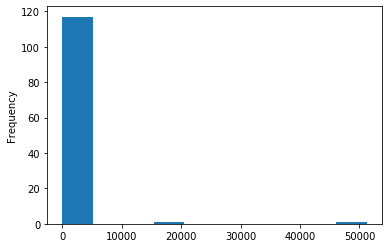

In [48]:
# check outliers of lead_source
df['lead_source'].value_counts().plot(kind='hist')

> there are outliers in lead source feature. 

In [49]:
# remove outliers of lead source where its freq. is less than 100
df=df.groupby('lead_source').filter(lambda x : len(x)>=100)


In [50]:
# check the unique values of lead source
n_unique(df,'lead_source')

19

In [51]:
# check the unique lead source
df['lead_source'].value_counts()>=100

facebook               True
google                 True
website                True
personal               True
organic search         True
phone                  True
hotline                True
app                    True
google landing page    True
landing page           True
organic form           True
whatsapp               True
sms                    True
vodafone               True
unknown                True
client referral        True
propertyfinder         True
intercom               True
direct traffic         True
Name: lead_source, dtype: bool

In [52]:
# remove rows where lead source is unknown
df=df[df['lead_source']!="unknown"]

In [53]:
df.shape

(87907, 7)

In [54]:
# check the unique values in lead source
d_unique(df,'lead_source')

array(['google', 'facebook', 'app', 'organic search', 'landing page',
       'website', 'sms', 'whatsapp', 'phone', 'propertyfinder',
       'vodafone', 'intercom', 'hotline', 'direct traffic',
       'client referral', 'organic form', 'google landing page',
       'personal'], dtype=object)

In [55]:
# check the unique values of campaign
n_unique(df,'campaign')


514

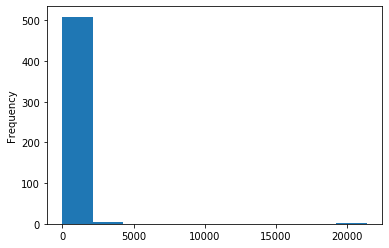

In [56]:
# check outliers of campaign
df['campaign'].value_counts().plot(kind='hist')

> There are outliers in campaign feature.

In [57]:
# check the number of unique values in campaign
n_unique(df,'campaign')

514

In [58]:
#check the number of none values in campaign
df.query('campaign=="none"').shape[0]

21355

In [59]:
#check the number of unqualifed leads whoes campagin value is none
df.query('campaign=="none" & low_qualified==0').shape[0]

17595

In [60]:
# remove the unqualifed leads whose campaign is none
df=df.query('(campaign!="none" & low_qualified==0)|(campaign=="none" & low_qualified==1) |(campaign!="none" & low_qualified==1)')

In [61]:
# remove none values from campaign
#df=df[df['campaign']!="none"]

In [62]:
# remove outliers in campaign
#df=df.groupby('campaign').filter(lambda x : len(x)>=500)


In [63]:
# check the number of unique values in campaign
n_unique(df,'campaign')

514

In [64]:
# check the unique values in campaign
d_unique(df,'campaign')

array(['sodic', 'orascom lead generation', 'locations',
       'city edge lead generation', 'inertia egypt',
       'gouna generic lead generation',
       'emaar lead generation cooing new', 'tmg lead generation cooing',
       'tatweer misr lead generation new cooing',
       'palm hills lead generation', 'misr italia',
       'hassan allam lead generation',
       'reedy group lead generation cooing new', 'equity',
       'inertia lead generation cooing', 'google cpc', 'mountain view',
       'sodic lead generation',
       'modon elopments lead generation cooing new',
       'ora elopers lead generation new cooing',
       'mountain view lead generation cooing',
       'palm hills lead generation new cooing',
       'palm hills lead generation cooing new',
       'arabella lead generation cooing',
       'modon elopments lead generation', 'palmhillssms', 'marakez',
       'starlight elopments', 'eloper x lead generation',
       'la vista elopments lead generation cooing',
       '

In [65]:
# check the shape of the data
df.shape

(70312, 7)

In [66]:
# check the shape of the data of campaign =false for qualifed leads
df.query('campaign=="false" & low_qualified==1').shape[0]


24

In [67]:
# drop campaign=false rows
df=df[df['campaign']!="false"]


In [68]:
# check the shape of the data
df.shape

(70094, 7)

> I decided to not remove outliers from campaign and deal with it because lots of information will be lost and also to not remove the none values for the qualifed leads as i need the information about the qualifed leads more than the unqualifed leads as it is smaller than the unqualifed leads, I decided to remove it from the unqualifed leads  as I will handle the problem of imbalanced dataset latter as well as rows of campaign=false as they are small.

In [69]:
# map arabic lang. campaign with english
df['campaign'] = df['campaign'].replace(['مدينة المستقبل', 'هيليوبوليس الجديدة', 'سوماباي','الساحل الشمالي','العين السخنة','العاصمة الأدارية الجديدة','القاهرة الجديدة','المنصورة الجديدة','مراسي','الشروق','السادس من اكتوبر'], ['sixth of october','alshuruq','marasi','new mansoura','new cairo','The new administrative capital','ain sukhna','north coast','sumabay','new heliopolis','future city'])

In [70]:
# check the unique campaign
d_unique(df,'campaign')

array(['sodic', 'orascom lead generation', 'locations',
       'city edge lead generation', 'inertia egypt',
       'gouna generic lead generation',
       'emaar lead generation cooing new', 'tmg lead generation cooing',
       'tatweer misr lead generation new cooing',
       'palm hills lead generation', 'misr italia',
       'hassan allam lead generation',
       'reedy group lead generation cooing new', 'equity',
       'inertia lead generation cooing', 'google cpc', 'mountain view',
       'sodic lead generation',
       'modon elopments lead generation cooing new',
       'ora elopers lead generation new cooing',
       'mountain view lead generation cooing',
       'palm hills lead generation new cooing',
       'palm hills lead generation cooing new',
       'arabella lead generation cooing',
       'modon elopments lead generation', 'palmhillssms', 'marakez',
       'starlight elopments', 'eloper x lead generation',
       'la vista elopments lead generation cooing',
       '

In [71]:
# drop customer name column
df.drop('customer_name',axis=1,inplace=True)

In [72]:
# print the head
df.head()

,lead_id,message,lead_time,lead_source,campaign,low_qualified
0,22,message: Idea about the best area in Sheik Za...,2022-03-07 12:56:20.523509,google,sodic,0
1,30,ad_id : 23843176891470664 form_id : 367745493...,2019-09-16 13:17:18.459000,facebook,orascom lead generation,0
2,42,message:,2022-05-07 02:03:53.589687,google,locations,0
3,44,ad_id : 23844249544660664 adset_id : 23844249...,2019-12-19 22:56:46.662000,facebook,city edge lead generation,0
4,48,message:,2022-01-27 05:56:22.806753,google,inertia egypt,0


### Feature Engineering

In [73]:
# function that translate the arabic name or string to english
def translate_arabic(name):
    if name.isascii()==False: 
        translator = Translator(from_lang="arabic", to_lang="english")
        name = translator.translate(name)
    return name

In [74]:
# function to convert the names to male and female
def gendre(name):
    if name[0] in names.words('male.txt'):
        return 'male'
    elif name[0] in names.words('female.txt'):
        return 'female'
    else:
        return 'null'
    

In [75]:
#df['customer_name']=df['customer_name'].apply(lambda n:   gendre(n))


In [76]:
# create date function to create day,month,year,hour features
def create_date(df):
    df['day'] = df['lead_time'].dt.day
    df['month'] = df['lead_time'].dt.month
    df['year'] = df['lead_time'].dt.year
    df['hour'] = df['lead_time'].dt.hour

In [77]:
# create date features
create_date(df)

In [78]:
df.head()

,lead_id,message,lead_time,lead_source,campaign,low_qualified,day,month,year,hour
0,22,message: Idea about the best area in Sheik Za...,2022-03-07 12:56:20.523509,google,sodic,0,7,3,2022,12
1,30,ad_id : 23843176891470664 form_id : 367745493...,2019-09-16 13:17:18.459000,facebook,orascom lead generation,0,16,9,2019,13
2,42,message:,2022-05-07 02:03:53.589687,google,locations,0,7,5,2022,2
3,44,ad_id : 23844249544660664 adset_id : 23844249...,2019-12-19 22:56:46.662000,facebook,city edge lead generation,0,19,12,2019,22
4,48,message:,2022-01-27 05:56:22.806753,google,inertia egypt,0,27,1,2022,5


In [79]:
# drop lead_time column
df.drop(['lead_time','lead_id'],axis=1,inplace=True)

In [80]:
# message preprocess function
def message_preprocess(text):
    #remove links
    text = re.sub(r'https?:\/\/.*', '', text)
    # replace numbers
    text = re.sub("\d+", " ", text)
    # replace not word characters    
    text = re.sub(r'[^\w]+', ' ', text)
    # convert string to lowercase
    text=text.lower().strip()
    # remove extra spaces
    text=re.sub(' +', ' ',text)
    # Lemmatize the word
    lem=WordNetLemmatizer()
    lem.lemmatize(text)
    return text
    

In [81]:
# apply message preprocess function on message column
df['message'] = df['message'].apply(lambda t:message_preprocess(t))
df['message']

0        message idea about the best area in sheik zaid...
1                        ad_id form_id platform fb lead_id
2                                                  message
3        ad_id adset_id campaign_id confirm_your_phone_...
4                                                  message
                               ...                        
91124    ad_id adgroup_id adset_id campaign_id confirm_...
91125    ad_id adgroup_id adset_id campaign_id created_...
91126                                              message
91127    ad_id adgroup_id adset_id campaign_id created_...
91128    ad_id adgroup_id adset_id campaign_id created_...
Name: message, Length: 70094, dtype: object

In [82]:
# apply CountVectorizer to message column
vectorizer = CountVectorizer(strip_accents='ascii',stop_words='english',max_features=50)
mv = vectorizer.fit_transform(df['message'])
vectorizer.get_feature_names()

['__',
 '___',
 'ad_id',
 'adgroup_id',
 'adset_id',
 'answer',
 'apartment',
 'author_id',
 'author_type',
 'background',
 'best_time_to_call',
 'body',
 'border',
 'called',
 'campaign_id',
 'class',
 'code',
 'color',
 'confirm_your_number',
 'confirm_your_phone_number',
 'confirm_your_phone_number_',
 'created_time',
 'details',
 'egypt',
 'facebook_id',
 'fb',
 'ff',
 'form_id',
 'ig',
 'information',
 'interested',
 'leadgen_id',
 'like',
 'location',
 'looking',
 'message',
 'need',
 'new',
 'padding',
 'page_id',
 'platform',
 'pre',
 'promo',
 'px',
 'radius',
 'request',
 'span',
 'status',
 'style',
 'url']

In [83]:
# append message features after applying count vectorizer
df[vectorizer.get_feature_names()]=mv.toarray().tolist()

In [84]:
# drop unuseful feature
df.drop(['__','___','ad_id','adgroup_id','adset_id','author_id','author_type','body','border','class','code','color','confirm_your_number','confirm_your_phone_number_',
 'created_time','facebook_id','fb','ff','form_id','ig','leadgen_id','message','padding','page_id','platform','pre','promo','px','radius','request','span','status','style','url'],axis=1,inplace=True)

In [85]:
df.head()

,lead_source,campaign,low_qualified,day,month,year,hour,answer,apartment,background,...,confirm_your_phone_number,details,egypt,information,interested,like,location,looking,need,new
0,google,sodic,0,7,3,2022,12,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,facebook,orascom lead generation,0,16,9,2019,13,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,google,locations,0,7,5,2022,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,facebook,city edge lead generation,0,19,12,2019,22,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,google,inertia egypt,0,27,1,2022,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [86]:
# applying one hot encode on lead_source and campagin features
df = pd.get_dummies(data=df, columns=['lead_source','campaign'])


In [87]:
df.head()

,low_qualified,day,month,year,hour,answer,apartment,background,best_time_to_call,called,...,campaign_village west oms,campaign_vresidence,campaign_vye,campaign_vye bedroom,campaign_webretargeting,campaign_zed,campaign_zed east,campaign_zed east a b testing lead generation,campaign_zed west,campaign_zedeastsms
0,0,7,3,2022,12,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,16,9,2019,13,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,7,5,2022,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,19,12,2019,22,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,27,1,2022,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [94]:
# save the transformed dataset
engine=create_engine('sqlite:///nawytransformed.db')
df.to_sql('nawytransformed', engine, index=False)